In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import numpy as np

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



# Bayesian Model of Facebook ad spend. 

- My data source is synthetic data but inspired by some data used in a real-world project. 



In [2]:
%matplotlib inline

In [3]:
import os
conversion_data = '../data/conversion_data.csv'

In [4]:
data = """
interest	conversions	impressions
2	19	1727646
7	19	2622588
10	91	17989844
15	63	10745856
16	141	31799775
18	33	8646488
19	33	6083217
20	48	6899804
21	25	2833490
22	12	3965401
23	7	1836368
24	15	2256874
25	20	5251853
26	23	4868639
27	54	16352527
28	42	10959630
29	132	18768653
30	13	2191807
31	15	1074288
32	35	6455261
36	10	922928
63	34	8365640
64	27	5085460
65	19	1737547
66	4	893407
100	9	2023690
101	25	2960453
102	7	1160953
103	5	1921053
104	8	1412110
105	6	2656351
106	5	1592431
107	20	4482111
108	7	2763404
109	8	2980365
110	9	2434719
111	10	1490896
112	15	2324572
113	7	1830565
114	4	1066164
"""

In [5]:
import io
df = pd.read_table(io.StringIO(data))

In [6]:
df.head()

,interest,conversions,impressions
0,2,19,1727646
1,7,19,2622588
2,10,91,17989844
3,15,63,10745856
4,16,141,31799775


Let's add some features and convert some of the dtypes to categories.

Let's think this through. Lets try to model the approved conversion (which in this data set is the actual conversion we're interested in. It's the conversion after clicking on an ad). We'll use a binomial model because we want to model 'convert or not'. 

We'll use interest group as our Hierachy. 

In [7]:
df.interest = df.interest.astype('category')
interests = df['interest'].as_matrix()

In [8]:
len(set(df.interest))

40

Let's extract impressions - which is number of facebook ads shown and conversion which is the actual number who clicked on that ad. 

In [9]:
# Extract the data we need as numpy arrays
impressions = df['impressions'].as_matrix()

conversion = df['conversions'].as_matrix()

In [10]:
df.impressions.values

array([ 1727646,  2622588, 17989844, 10745856, 31799775,  8646488,
        6083217,  6899804,  2833490,  3965401,  1836368,  2256874,
        5251853,  4868639, 16352527, 10959630, 18768653,  2191807,
        1074288,  6455261,   922928,  8365640,  5085460,  1737547,
         893407,  2023690,  2960453,  1160953,  1921053,  1412110,
        2656351,  1592431,  4482111,  2763404,  2980365,  2434719,
        1490896,  2324572,  1830565,  1066164])

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


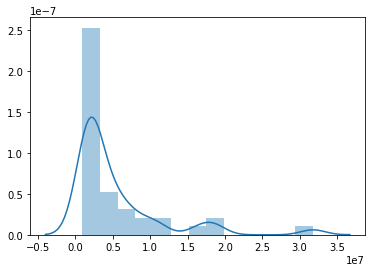

In [11]:
sns.distplot(impressions)

We can see our distribution for impressions is clearly not normal. So we should use maybe a hyperprior to represent that. 

So say a hyperprior that is exponential. 

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


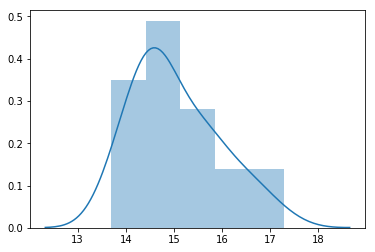

In [12]:
sns.distplot(np.log(impressions))

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


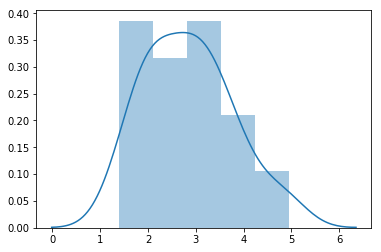

In [13]:
sns.distplot(np.log(conversion))

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


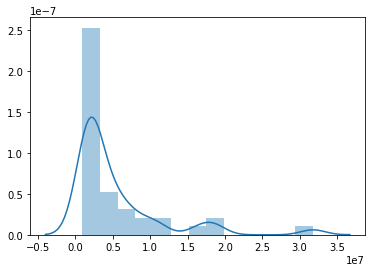

In [14]:
sns.distplot(impressions)

In [15]:
df

,interest,conversions,impressions
0,2,19,1727646
1,7,19,2622588
2,10,91,17989844
3,15,63,10745856
4,16,141,31799775
5,18,33,8646488
6,19,33,6083217
7,20,48,6899804
8,21,25,2833490
9,22,12,3965401


In [16]:
impressions.dtype

dtype('int64')

/Users/peadarcoyle/miniconda3/envs/stat-rethink-pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


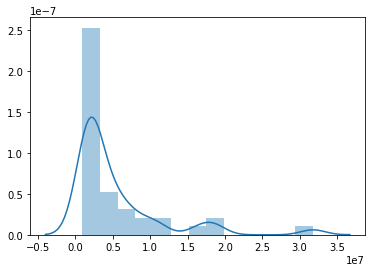

In [17]:
sns.distplot(impressions)

In [18]:
conversion = conversion.astype(int)
impressions = impressions.astype(int)

In [19]:

 
def ad_model2(impressions, conversions):
    N = len(impressions)
    with pm.Model() as model:
        phi_log = pm.Uniform('phi_log', lower=0, upper=30)
        kappa_log = pm.Uniform('kappa_log', lower=-10, upper=30)
        
        alpha_log = pm.Deterministic('alpha_log', kappa_log-(phi_log/2))
        alpha = pm.Deterministic('alpha', 2**alpha_log)
        
        beta_log = pm.Deterministic('beta_log', kappa_log+(phi_log/2))
        beta = pm.Deterministic('beta', 2**beta_log)
        
        thetas = pm.Beta('thetas', alpha=alpha, beta=beta, shape=N)

        y = pm.Binomial('y', n=impressions, p=thetas, observed=conversions)
        return model


In [20]:
my_model = ad_model2(impressions, conversion)
print(my_model.check_test_point())

kappa_log_interval__      -1.39
phi_log_interval__        -1.39
thetas_logodds__          -2.69
y                      -3647.82
Name: Log-probability of test_point, dtype: float64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi_log]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:22<00:00, 435.06draws/s]


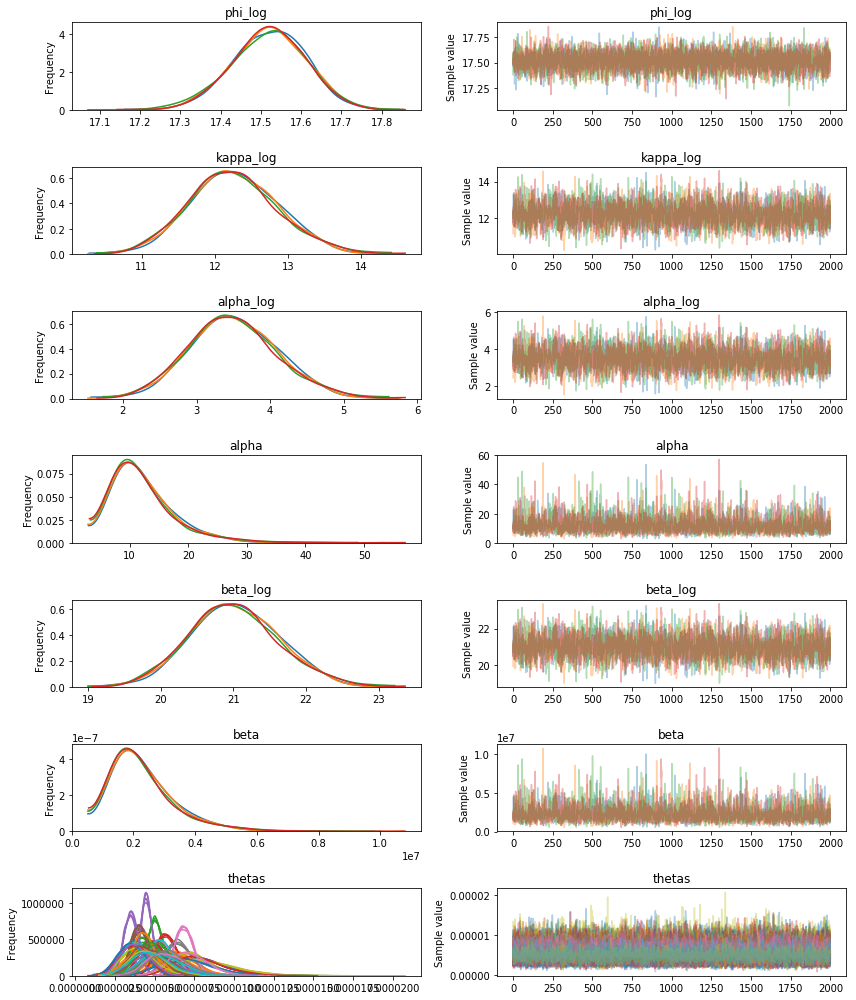

In [21]:
with ad_model2(impressions, conversion):
    trace = pm.sample(2000,
                      nuts_kwargs={'target_accept': 0.99})
    pm.traceplot(trace)

Specifically, what pooling am I doing here? 

I've got a formula of some description.

Which is the standard Hierachical Binomial model. 

In [22]:
set(df.interest);

We can see here that our model mixed correctly. So we can say that our model is well-specified. If there was a big gap between the marginal energy distribution and the energy transform distribution we would say the model hadn't mixed well. 

For more information on the underlying theory of NUTS - I recommend the canonical text by Mike Betancourt - https://arxiv.org/pdf/1701.02434.pdf

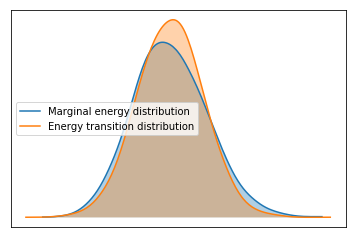

In [23]:
pm.plots.energyplot(trace)

In [24]:
interest_categories= list(set(df.interest))

We can see here the top 5 thetas. 

In [25]:
df_trace = pd.DataFrame(pm.summary(trace, varnames=['thetas']))
df_trace.sort_values(by='mean')[:5]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thetas__14,0.000004,4.476810e-07,4.364370e-09,0.000003,0.000004,11407.296235,0.999825
thetas__30,0.000004,9.024156e-07,9.469925e-09,0.000002,0.000005,9527.800218,0.999852
thetas__33,0.000004,9.189776e-07,1.037128e-08,0.000002,0.000005,8907.215944,0.999901
thetas__34,0.000004,8.739636e-07,8.288631e-09,0.000002,0.000006,9741.586199,0.999942
thetas__9,0.000004,8.071342e-07,7.308961e-09,0.000002,0.000005,10512.133794,0.999903


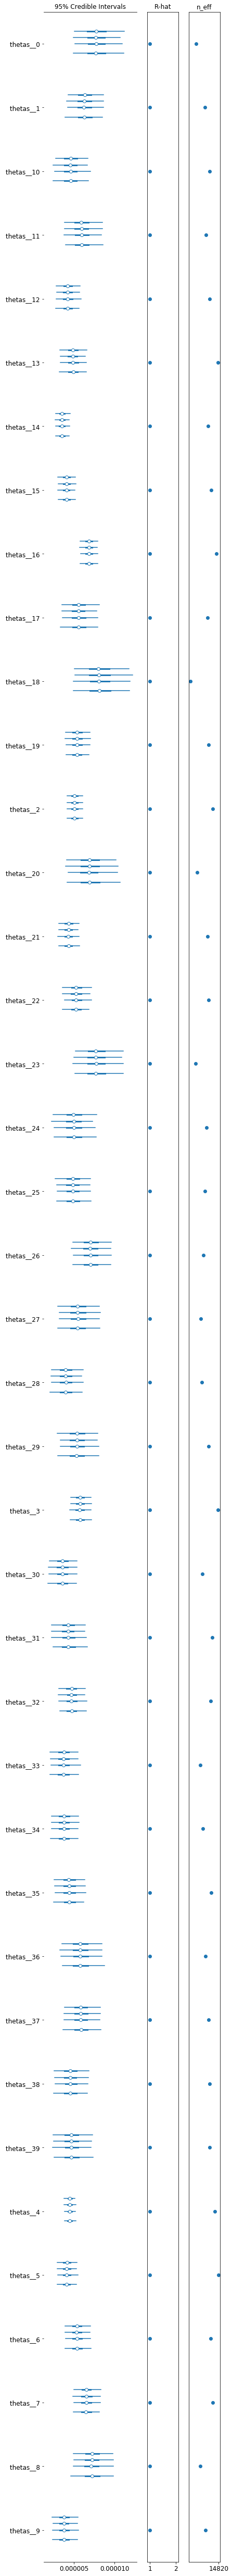

In [26]:
import arviz
arviz.forestplot(trace, varnames=['thetas'])

# Summary
You can see here for example that thetas_8 
(which is a particular interest group) is more likely to convert than thetas_9.

We've also seen our top thetas. 

In this example we've not dug deep into what each theta is exactly. I leave that as an exercise for the reader - see if you can generate a
dataframe or visualization with the correct interest categories listed. 

However in a real world example interest category would probably be something like 'cars', 'bikes', 'toddler toys' and from that you'd probably be able to better target ads
with an understanding of the uncertainty of your response. 